In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
import smtplib
from os.path import basename
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.utils import COMMASPACE, formatdate

def noticeEMail(usr, psw, send_from, send_to, subject, text, files=None):
    assert isinstance(send_to, list)
    
    msg = MIMEMultipart()
    msg['From'] = send_from
    msg['To'] = COMMASPACE.join(send_to)
    msg['Date'] = formatdate(localtime=True)
    msg['Subject'] = subject

    msg.attach(MIMEText(text))

    for f in files or []:
        with open(f, "rb") as fil:
            part = MIMEApplication(
                fil.read(),
                Name=basename(f)
            )
        # After the file is closed
        part['Content-Disposition'] = 'attachment; filename="%s"' % basename(f)
        msg.attach(part)
    
    server=smtplib.SMTP('smtp.gmail.com:587')
    server.starttls()
    server.login(usr,psw)
    server.sendmail(send_from, send_to, msg.as_string())
    server.quit()

In [124]:
usr = 'vitaliy.kozin@phystech.edu'
psw = '...'
send_from = 'vitaliy.kozin@phystech.edu'
subject = 'Autoencoder progress'
send_to = ['vkozin97@gmail.com']

In [2]:
from mnist import MNIST
mndata = MNIST('./data/mnist/')
x_train, labels_train = mndata.load_training()
x_test, labels_test = mndata.load_testing()

x_train = np.reshape(x_train, (-1, 28, 28, 1)) / 255.
x_test = np.reshape(x_test, (-1, 28, 28, 1)) / 255.

labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

In [3]:
labels_names = list(map(str, range(10)))
len(labels_names)

10

In [2]:
from __future__ import print_function
import keras
import h5py
import pickle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input, Concatenate, UpSampling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from PIL import Image
import numpy as np
import os
from time import clock

batch_size = 32
num_classes = 10
epochs = 200
data_augmentation = False
save_dir = os.path.join(os.getcwd(), 'saved_models_mnist')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_name = 'keras_mnist_no_augmentation'

Using TensorFlow backend.


In [5]:
needed_class = 7

def make_y(x, labels, needed_class):
    return np.array([x[i] if labels[i] == needed_class else np.zeros(x.shape[1:]) + 0.5 for i in range(x.shape[0])])

y_train = make_y(x_train, labels_train, needed_class)
y_test = make_y(x_test, labels_test, needed_class)

In [8]:
def get_encoder(inp):
    
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(inp)
    maxpool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    #dropout1 = Dropout(0.1)(maxpool1)
    
    conv2 = Conv2D(32, (3, 3), padding='same', activation='relu')(maxpool1)
    maxpool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)
    dropout2 = Dropout(0.15)(maxpool2)
    
    #conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(dropout2)
    #maxpool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)
    #dropout3 = Dropout(0.15)(maxpool3)
    
    reshape1 = Reshape((-1,))(dropout2)
    dense1 = Dense(64, activation='relu')(reshape1)
    
    return dense1


def get_decoder(encoder):
    
    dense2 = Dense(7 * 7, activation='relu')(encoder)
    reshape2 = Reshape((7, 7, -1))(dense2)
    
    #conv4 = Conv2D(64, (3, 3), padding='same', activation='relu')(dropout3)
    #upsample1 = UpSampling2D((2, 2))(conv4)
    #dropout4 = Dropout(0.15)(upsample1)
    
    conv5 = Conv2D(32, (3, 3), padding='same', activation='relu')(reshape2)
    upsample2 = UpSampling2D((2, 2))(conv5)
    #dropout5 = Dropout(0.1)(upsample2)
    
    conv6 = Conv2D(32, (3, 3), padding='same', activation='relu')(upsample2)
    upsample3 = UpSampling2D((2, 2))(conv6)
    dropout6 = Dropout(0.15)(upsample3)
    
    conv8 = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(dropout6)
    
    return conv8


def build_encoder_decoder_model(input_shape, lr, decay):

    inp = Input(shape=input_shape, dtype="float32")
    
    encoder = get_encoder(inp)
    decoder = get_decoder(encoder)
    
    model = Model(inp, decoder)
    opt = keras.optimizers.rmsprop(lr=lr, decay=decay)
    #opt.lr = lr
    #opt.decay = decay
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])
    
    return model


def build_encoder_dense_model(input_shape, num_classes, lr, decay):
    
    inp = Input(shape=input_shape, dtype="float32")
    
    encoder = get_encoder(inp)
    dense2 = Dense(num_classes, activation='softmax') (encoder)
    
    model = Model(inp, dense2)
    opt = keras.optimizers.rmsprop(lr=lr, decay=decay)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [9]:
model = build_encoder_decoder_model(x_train.shape[1:], 0.0001, 1e-6)

print('Model summary:')
print(model.summary())

Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1568)              0     

In [10]:
def gen_dataset_stratified_by_needed_class(x, y, labels, needed_class, shuffle=True):
    indexes = (labels == needed_class)
    res_x = x[indexes]
    res_y = y[indexes]
    indexes = np.arange(len(labels))[labels != needed_class]
    indexes = np.random.choice(indexes, res_x.shape[0])
    res_x = np.concatenate((res_x, x[indexes]))
    res_y = np.concatenate((res_y, y[indexes]))
    indexes = np.arange(res_x.shape[0])
    if shuffle:
        np.random.shuffle(indexes)
    return res_x[indexes], res_y[indexes]

In [11]:
def fit_model(model, x_train, y_train, x_test, y_test, labels_train, labels_test, needed_class, epochs, data_augmentation=True, verbose=False):
    histories = []
    validation_data = []
    
    if not data_augmentation:
        for epoch in range(epochs):
            if verbose:
                print('epoch ' + str(epoch + 1) + '/' + str(epochs), end=' ')
            t = clock()
            x, y =  gen_dataset_stratified_by_needed_class(x_train, y_train, labels_train, needed_class, shuffle=False)
            histories.append(
                model.fit(x, y,
                          batch_size=batch_size,
                          epochs=1,
                          verbose=0,
                          #validation_data=(x_test, y_test),
                          shuffle=True,
                          #sample_weight = (labels_train == needed_class) * 8 + 1,
                          #initial_epoch = epoch
                         ).history
            )
            x, y = gen_dataset_stratified_by_needed_class(x_test, y_test, labels_test, needed_class, shuffle=False)
            validation_data.append(
                model.evaluate(x, y, verbose=0)
            )
            if verbose:
                print('loss - ' + str(histories[-1].history['loss']) + ', validation loss - ' + str(validation_data[-1]), end = '; time: ')
                print(str(clock() - t) + ' sec')

    else:
        if verbose:
            print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,
            )  # randomly flip images

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)

        # Fit the model on the batches generated by datagen.flow().
        for epoch in range(epochs):
            #K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr) * 1. / (1. + decay * epoch))
            #lrs.append(K.get_value(model.optimizer.lr))

            if verbose:
                print('epoch ' + str(epoch + 1) + '/' + str(epochs), end=': ')
            t = clock()
            x, y =  gen_dataset_stratified_by_needed_class(x_train, y_train, labels_train, needed_class)
            histories.append(
                model.fit_generator(datagen.flow(x, y,
                                                 batch_size=batch_size),
                                    steps_per_epoch=int(np.ceil(x.shape[0] / float(batch_size))),
                                    epochs=1,
                                    verbose=0,
                                    #validation_data=(x_test, y_test),
                                    #sample_weight = (labels_train == needed_class) * 8 + 1,
                                    initial_epoch=0,
                                    workers=4,
                                    max_queue_size=5
                                    ).history
            )
            x, y = gen_dataset_stratified_by_needed_class(x_test, y_test, labels_test, needed_class, shuffle=False)
            validation_data.append(
                model.evaluate(x, y, verbose=0)
            )
            if verbose:
                print('loss - ' + str(histories[-1].history['loss']) + ', validation loss - ' + str(validation_data[-1]), end = '; time: ')
                print(str(int(clock() - t)) + ' sec')
                
    return histories, validation_data

In [12]:
import pickle

In [13]:
histories = []
validation_data = []

verbose = False
use_email = True

lr = 0.0001
decay = 1e-6

data_augmentation = False

for needed_class in range(num_classes):
    t = clock()
    y_train = make_y(x_train, labels_train, needed_class)
    y_test = make_y(x_test, labels_test, needed_class)
    
    model = build_encoder_decoder_model(x_train.shape[1:], lr, decay)
    
    s = 'Training class #' + str(needed_class) + '\n'
    print(s, end='')
    if use_email:
        noticeEMail(usr, psw, send_from, send_to, subject, s)
    
    hist, valid = fit_model(model, x_train, y_train, x_test, y_test, labels_train, labels_test, needed_class, epochs, verbose=verbose, data_augmentation=data_augmentation)
    histories.append(hist)
    validation_data.append(valid)
    
    try:
        s = 'Trained ' + str(clock() - t) + ' sec'
        if not verbose:
            print(s)
        if use_email:
            noticeEMail(usr, psw, send_from, send_to, subject, s)

        model_path = os.path.join(save_dir, model_name + '_' + str(needed_class) + '.h5')
        model.save(model_path)

        if not verbose:
            print('Saved trained model at %s ' % model_path)

        print('_' * 20)
        print()

        with open(save_dir + '/histories', 'wb') as f:
            pickle.dump(histories, f)
        with open(save_dir + '/validation_data', 'wb') as f:
            pickle.dump(validation_data, f)
    except Exception:
        s = 'something went wrong on class ' + str(needed_class)
        print(s)
        if use_email:
            noticeEMail(usr, psw, send_from, send_to, subject, s)

Training class #0
Trained 734.335983 sec
Saved trained model at /home/dl3/v.kozin/selective_autoencoder/saved_models_mnist/keras_mnist_no_augmentation_0.h5 
____________________

Training class #1
Trained 854.2822160000001 sec
Saved trained model at /home/dl3/v.kozin/selective_autoencoder/saved_models_mnist/keras_mnist_no_augmentation_1.h5 
____________________

Training class #2
Trained 781.1212759999999 sec
Saved trained model at /home/dl3/v.kozin/selective_autoencoder/saved_models_mnist/keras_mnist_no_augmentation_2.h5 
____________________

Training class #3
Trained 801.1115220000002 sec
Saved trained model at /home/dl3/v.kozin/selective_autoencoder/saved_models_mnist/keras_mnist_no_augmentation_3.h5 
____________________

Training class #4
Trained 762.2074339999999 sec
Saved trained model at /home/dl3/v.kozin/selective_autoencoder/saved_models_mnist/keras_mnist_no_augmentation_4.h5 
____________________

Training class #5
Trained 697.6512239999997 sec
Saved trained model at /home/

In [2]:
needed_class = 0
plt.plot(range(len(histories[needed_class])), [x['loss'] for x in histories[needed_class]])

NameError: name 'plt' is not defined

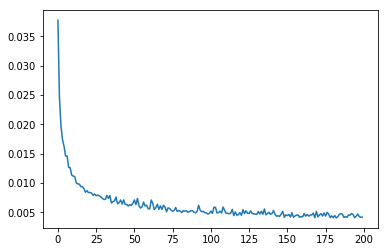

In [15]:
needed_class = 0
plt.plot(range(len(validation_data[needed_class])), [x[0] for x in validation_data[needed_class]])

In [16]:
if use_email:
    #for needed_class in range(num_classes):
    #    noticeEMail(usr, psw, send_from, send_to, subject, 'net for class ' + str(needed_class),
    #                [os.path.join(save_dir, model_name + '_' + str(needed_class) + '.h5')])
    
    noticeEMail(usr, psw, send_from, send_to, subject, 'net for class ' + str(needed_class),
                [save_dir + '/' + model_name + '_' + str(i) + '.h5' for i in range(10)])

In [17]:
if use_email:
    noticeEMail(usr, psw, send_from, send_to, subject, 'History of training',
                [os.path.join(save_dir, 'histories'),
                 os.path.join(save_dir, 'validation_data')])

In [13]:
def my_norm(img, projection):
    img = np.array(img, dtype='float32')
    projection = np.array(projection, dtype='float32')
    return np.sqrt(((projection - projection.mean())**2).sum()) / np.sqrt(((img - img.mean())**2).sum())

def old_accuracy(model, x, labels, needed_class, treshold=0.5):
    pred = model.predict(x)
    pred = np.array([my_norm(x[i], pred[i]) for i in range(x.shape[0])])
    pred = np.clip(pred, 0, 1)
    labels = np.array(labels==needed_class, dtype=pred.dtype)
    return ((pred > treshold) == labels).mean()

def accuracy(x, labels):
    norms = np.zeros((x.shape[0], num_classes))
    for i in range(num_classes):
        model_path = os.path.join(save_dir, model_name + '_' + str(i) + '.h5')
        model = keras.models.load_model(model_path)
        pred = model.predict(x)
        norms[:, i] = [my_norm(x[i], pred[i]) for i in range(x.shape[0])]
    preds = norms.argmax(axis=1)
    return (preds == labels).mean()

In [51]:
%%time
acc = accuracy(x_train, labels_train)
print(acc)

0.79718
CPU times: user 5min 30s, sys: 28.7 s, total: 5min 59s
Wall time: 5min 14s


In [52]:
%%time
acc = accuracy(x_test, labels_test)
print(acc)

0.7359
CPU times: user 2min 19s, sys: 8.45 s, total: 2min 28s
Wall time: 2min 2s


In [18]:
lr = 1e-4
decay = 1e-6

model2 = build_encoder_dense_model(x_train.shape[1:], num_classes, lr, decay)
encoder_dense_name = 'encoder_dense_model'

print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
reshape_23 (Reshape)         (None, 1568)              0         
__________

In [19]:
%%time
one_hot_labels_train = keras.utils.to_categorical(labels_train, num_classes)
one_hot_labels_test = keras.utils.to_categorical(labels_test, num_classes)

history = model2.fit(x_train, one_hot_labels, validation_data=(x_test, one_hot_labels_test),
                     batch_size=batch_size, epochs=epochs, verbose=False).history

NameError: name 'one_hot_labels' is not defined

In [1]:
model2.save(save_dir + '/' + encoder_dense_name + '.h5')

with open(save_dir + '/' + encoder_dense_name + '_history', 'wb') as f:
    pickle.dump(history, f)

NameError: name 'model2' is not defined

In [ ]:
noticeEMail(usr, psw, send_from, send_to, subject, 'files for encoder_dense_model',
            [save_dir + '/' + encoder_dense_name + '.h5', save_dir + '/' + encoder_dense_name + '_history'])

In [ ]:
with open(save_dir + '/' + encoder_dense_name + '_history', 'rb') as f:
    history = pickle.load(f)

In [ ]:
plt.plot(range(len(history['val_acc'])), history['val_acc'])

In [10]:
%%time
needed_class = 9
model = keras.models.load_model(save_dir + '/' + model_name + '_' + str(needed_class) + '.h5')

CPU times: user 1.1 s, sys: 4 ms, total: 1.1 s
Wall time: 1.06 s


In [7]:
number = -1

9
2694


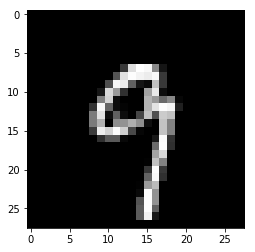

In [8]:
test_mode = True
isneeded = False
number += 1
if test_mode:
    index = np.random.choice([i for i in range(labels_test.shape[0]) if (labels_test[i] == needed_class) == isneeded])
    print(labels_names[labels_test[index]])
else:
    index = np.random.choice([i for i in range(labels_train.shape[0]) if (labels_train[i] == needed_class) == isneeded])
    print(labels_names[labels_train[index]])
print(index)
if test_mode:
    img = Image.fromarray(np.array(x_test[index].reshape((28, 28)) * 255, dtype='uint8'))#, interpolation='None')
    plt.imshow(np.array(x_test[index].reshape((28, 28))), interpolation='None', cmap='gray')
else:
    img = Image.fromarray(np.array(x_train[index].reshape((28, 28)) * 255, dtype='uint8'))#, interpolation='None')
    plt.imshow(np.array(x_train[index].reshape((28, 28))), interpolation='None', cmap='gray')
#img.save('data/test_photos_mnist/class_' + str(needed_class) + '_true.jpg')

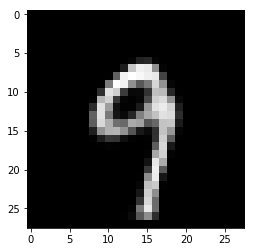

In [11]:
if test_mode:
    plt.imshow(model.predict(np.array([x_test[index]]))[0].reshape((28, 28)), interpolation='None', cmap='gray')
else:
    plt.imshow(model.predict(np.array([x_train[index]]))[0].reshape((28, 28)), interpolation='None', cmap='gray')

In [ ]:
def make_example_picture(test_mode = False, pict_size = (420, 470), start_imgs = (30, 30), start_table = (30, 80), stripes = (5, 5)):
    img_shape = x_train[0].shape
    
    real_images = []
    output_picture = np.zeros(pict_size + (3,)) + 1
    for real_class in range(num_classes):
        if test_mode:
            real_images.append(x_test[np.random.choice([i for i in range(labels_test.shape[0]) if (labels_test[i] == real_class)])])
        else:
            real_images.append(x_train[np.random.choice([i for i in range(labels_train.shape[0]) if (labels_train[i] == real_class)])])
        output_picture[start_imgs[0] + real_class * (img_shape[0] + stripes[0]) : start_imgs[0] + real_class * (img_shape[0] + stripes[0]) + img_shape[0],
                       start_imgs[1] : start_imgs[1] + img_shape[1], :] = real_images[-1]
        
    for model_class in range(num_classes):
        model = keras.models.load_model(save_dir + '/' + model_name + '_' + str(model_class) + '.h5')
        for real_class, real_image in enumerate(real_images):
            pred = model.predict(np.array([real_image]))[0]
            output_picture[start_table[0] + real_class * (img_shape[0] + stripes[0]) : start_table[0] + real_class * (img_shape[0] + stripes[0]) + img_shape[0],
                           start_table[1] + model_class * (img_shape[1] + stripes[1]) : start_table[1] + model_class * (img_shape[1] + stripes[1]) + img_shape[1],
                           :] = pred
    return Image.fromarray(np.array(output_picture * 255, dtype='uint8'))

In [ ]:
img = make_example_picture()
img

In [ ]:
examples_dir = 'data/examples_pictures_mnist'
if not os.path.isdir(examples_dir):
    os.makedirs(examples_dir)

In [ ]:
num_examples = 10
for test_mode in [True, False]:
    for i in range(num_examples):
        make_example_picture(test_mode = test_mode).save(examples_dir + '/example_' + ('test' if test_mode else 'train') + '_' + str(i) + '.jpg')

In [90]:
needed_class = 7
model = keras.models.load_model(save_dir + '/' + model_name + '_' + str(needed_class) + '.h5')

In [42]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

(450, 570)


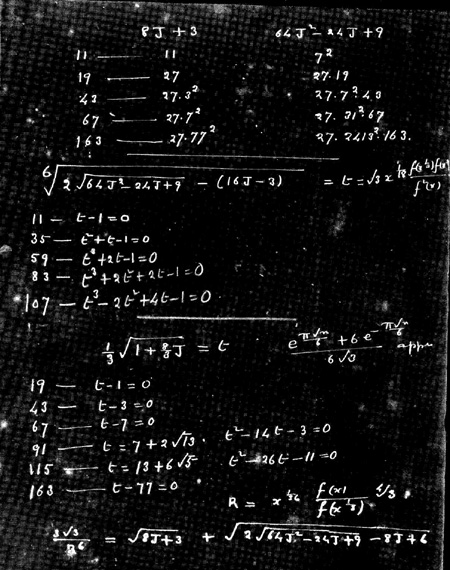

In [43]:
img = keras.preprocessing.image.load_img('data/test_photos_mnist/maths_writings.jpg')
img = img.convert('L')
arr = np.asarray(img.getdata(), dtype=np.uint8).reshape((img.size[1], img.size[0]))
arr = 255 - arr
img = Image.fromarray(arr, mode='L')
img.save('data/test_photos_mnist/maths_writings_black_white.jpg')
print(img.size)
img

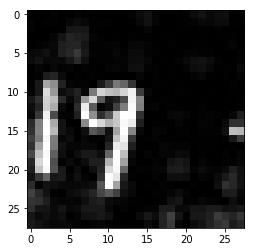

In [60]:
mini_img = img.crop((30, 370, 58, 398))#.resize((28, 28))
plt.imshow(np.array(mini_img) / 255, interpolation='None', cmap='gray')

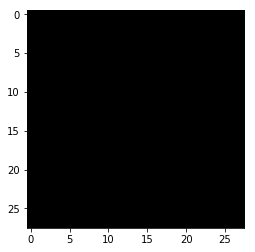

In [61]:
plt.imshow(model.predict(np.array([np.array(mini_img).reshape((28, 28, 1)) / 255.])).reshape((28, 28)), interpolation='None', cmap='gray')

In [81]:
def process_img_mean_by_windowing(img, model, window_size=(28, 28), horizontal_stripe=1, vertical_stripe=1):
    
    
    count = max(1, (img.size[0] - window_size[0] - 1) // horizontal_stripe + 2)
    horizontal_starts = np.arange(0, count * horizontal_stripe, horizontal_stripe)
    horizontal_starts -= ((count - 1) * horizontal_stripe + window_size[0] - img.size[0]) // 2
    #print(horizontal_starts)
    count = max(1, (img.size[1] - window_size[1] - 1) // vertical_stripe + 2)
    vertical_starts = np.arange(0, count* vertical_stripe, vertical_stripe)
    vertical_starts -= ((count - 1) * vertical_stripe + window_size[1] - img.size[1]) // 2
    #print(vertical_starts)
    
    if np.array(img).max() > 1:
        need_divide = True
    else:
        need_divide = False
    
    count = np.zeros((img.size[1], img.size[0]))
    res = np.zeros((img.size[1], img.size[0]))
    for start_i in vertical_starts:
        for start_j in horizontal_starts:
            #print(start_i, start_j)
            mini_img = img.crop((start_j, start_i, start_j + window_size[0], start_i + window_size[1]))
            if window_size != (28, 28):
                mini_img = mini_img.resize((28, 28))
            mini_img = np.array(mini_img)
            if need_divide:
                mini_img = mini_img / 255.
            arr = np.array([mini_img])
            if len(arr.shape) == 3:
                arr = arr.reshape((1, 28, 28, 1))
            transformed = model.predict(arr)[0]
            if transformed.shape[-1] == 1:
                transformed = transformed.reshape((28, 28))
            if window_size != (28, 28):
                if need_divide:
                    transformed = np.array(transformed * 255, dtype='uint8')
                transformed = np.array(Image.fromarray(transformed).resize(window_size), dtype='float32')
                if need_divide:
                    transformed /= 255.
            #print(transformed.shape)
            #print(max(0, -start_i), window_size[1] - max(0, start_i + window_size[1] - img.size[1]))
            #print(max(0, -start_j), window_size[0] - max(0, start_j + window_size[0] - img.size[0]))
            transformed = transformed[max(0, -start_i) : window_size[1] - max(0, start_i + window_size[1] - img.size[1]),
                                      max(0, -start_j) : window_size[0] - max(0, start_j + window_size[0] - img.size[0])]
            #print(transformed.shape)
            count[max(0, start_i) : max(0, min(img.size[1], start_i + window_size[1])),
                  max(0, start_j) : max(0, min(img.size[0], start_j + window_size[0]))] += 1
            res[max(0, start_i) : max(0, min(img.size[1], start_i + window_size[1])),
                max(0, start_j) : max(0, min(img.size[0], start_j + window_size[0]))] += transformed
    count += 1e-8
    res = res / count
    return res

(450, 570)


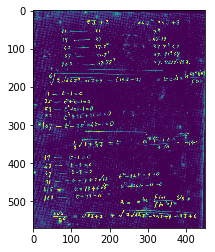

In [82]:
print(img.size)
plt.imshow(np.array(img))

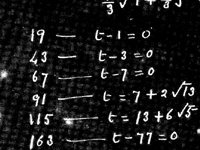

In [89]:
cropped

438.784039 sec


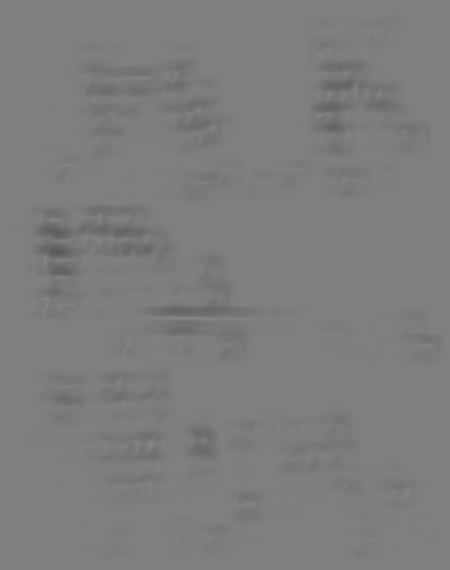

In [113]:
t = clock()
cropped = img.crop((0, 350, 200, 500))
processed = process_img_mean_by_windowing(img, model, window_size=(28, 28), horizontal_stripe=1, vertical_stripe=1)
print(clock() - t, 'sec')
processed_img = Image.fromarray(np.array(processed * 255, dtype='uint8'))
processed_img

In [114]:
processed_img.save('data/test_photos_mnist/processed_writings.jpg')

In [6]:
processed = np.array(Image.open('data/test_photos_mnist/processed_writings.jpg')) / 255.

In [7]:
print(processed.mean(), processed.std(), processed.max(), processed.min())

0.490562978252 0.0147281860403 0.529411764706 0.352941176471


In [8]:
def widen(img, coeff = None, use_sigmoid = False, return_coef = False):
    arr = np.array(img)
    m = arr.mean()
    if coeff is None:
        coeff = 2 / (arr.max() - arr.min())
        print(coeff)
    arr = (arr - m) * coeff + m
    if use_sigmoid:
        arr = 1 / (1 + np.exp(-arr))
    arr[arr > 1] = 1
    arr[arr < 0] = 0
    if return_coef:
        return arr, coef
    return arr

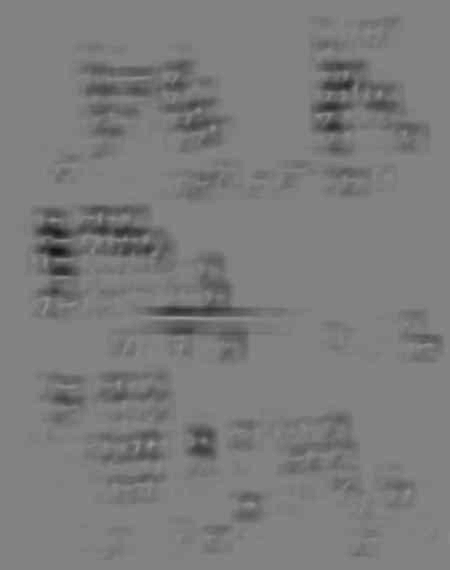

In [9]:
filtered = Image.fromarray(np.array(widen(processed, 3, False) * 255, dtype='uint8'))
filtered

In [10]:
filtered.save('data/test_photos_mnist/processed_writings_filtered_1.jpg')

11.3333333333


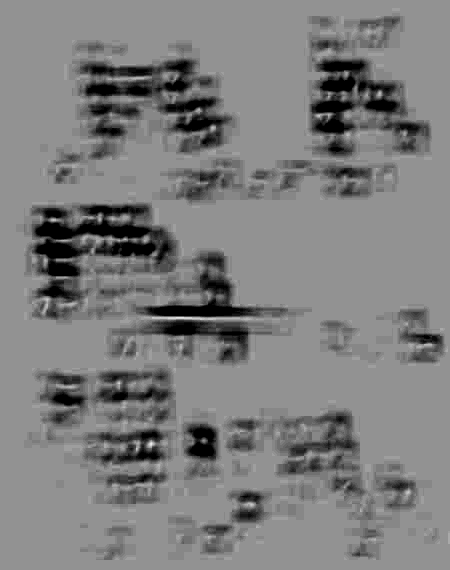

In [11]:
filtered = Image.fromarray(np.array(widen(processed) * 255, dtype='uint8'))
filtered

In [12]:
filtered.save('data/test_photos_mnist/processed_writings_filtered_2.jpg')

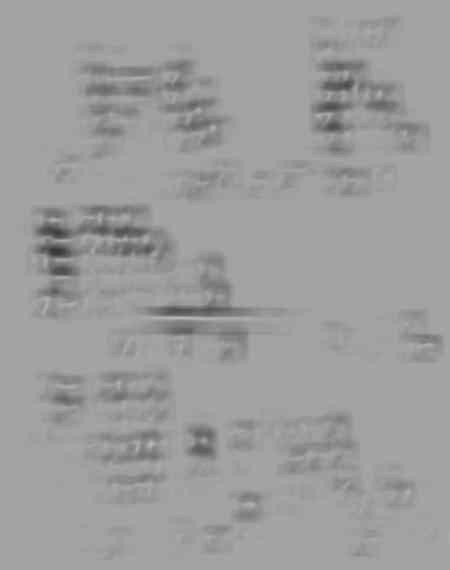

In [14]:
filtered = Image.fromarray(np.array(widen(processed, 13, True) * 255, dtype='uint8'))
filtered

In [18]:
filtered.save('data/test_photos_mnist/processed_writings_filtered_3.jpg')